Laboratorium

In [3]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()
        
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

<IPython.core.display.Javascript object>


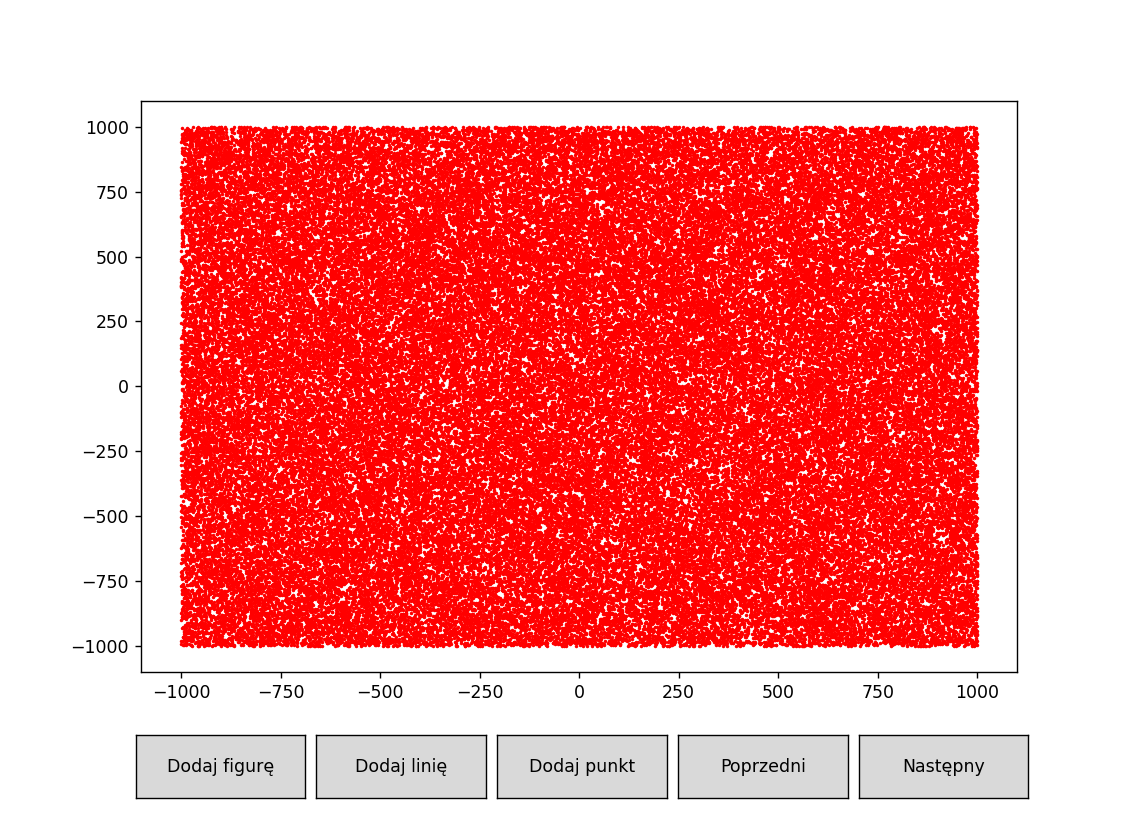

In [35]:
%matplotlib notebook

arrayA = []
for i in range(10**5):
    arrayA.append((np.random.uniform(-1000,1000),np.random.uniform(-1000,1000)))

plot = Plot(points = [PointsCollection(arrayA, color="red",s=1)]) # s=1 najmniejszy rozmiar punktu w wizualizacji
plot.draw()

<IPython.core.display.Javascript object>


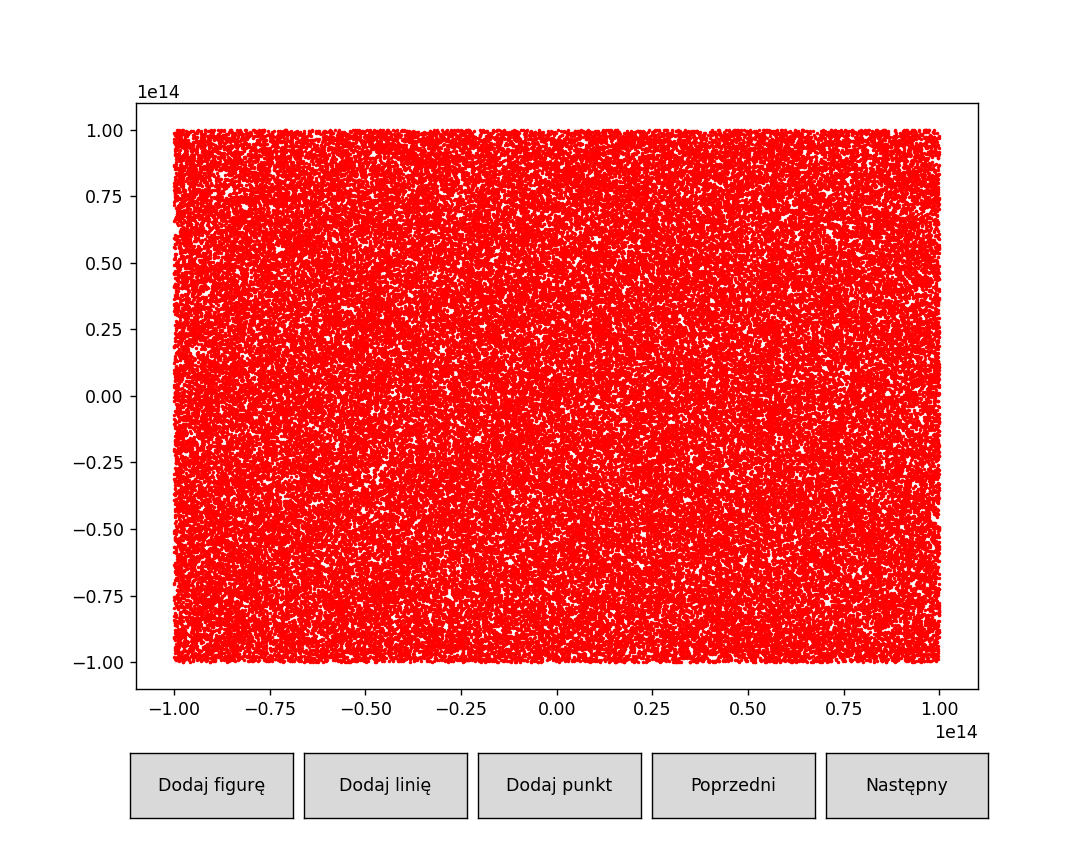

In [47]:
%matplotlib notebook

arrayB = []
for i in range(10**5):
    arrayB.append((np.random.uniform(-10**14,10**14),np.random.uniform(-10**14,10**14)))

plot = Plot(points = [PointsCollection(arrayB,color="red",s=1)])
plot.draw()

<IPython.core.display.Javascript object>


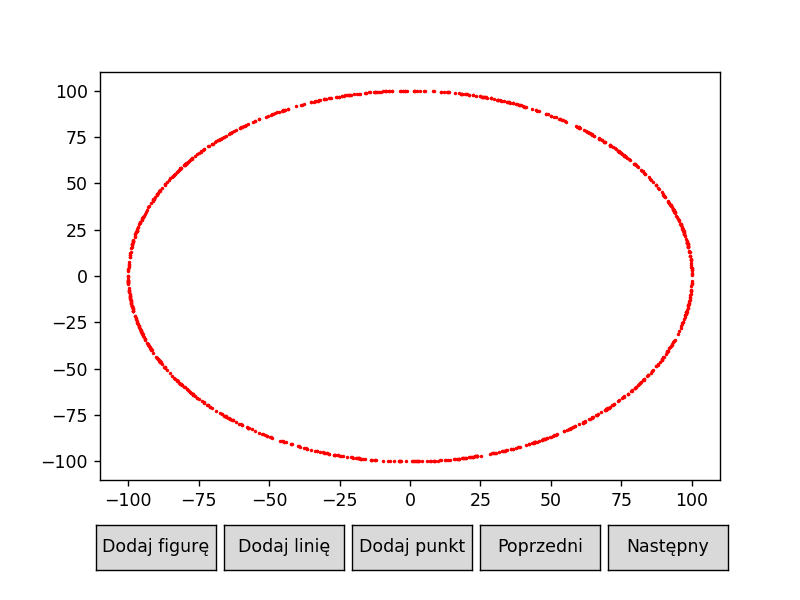

In [5]:
%matplotlib notebook

arrayC = []
radius = 100
for i in range(10**3):
    alpha = np.random.uniform(0,2*np.pi)
    arrayC.append((radius*np.cos(alpha),radius*np.sin(alpha)))

plot = Plot(points = [PointsCollection(arrayC,color="red",s=1)])
plot.draw()

<IPython.core.display.Javascript object>


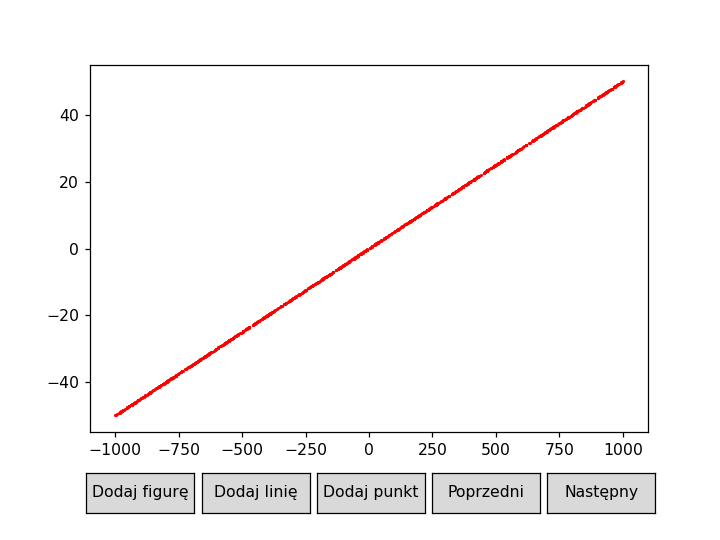

In [5]:
%matplotlib notebook

arrayD = []
v = [(-1.0,0.0),(1.0,0.1)]

for i in range(10**3):
    x = np.random.uniform(-1000,1000)
    factorA = ((v[0][1]-v[1][1])/(v[0][0]-v[1][0]))
    arrayD.append((x,factorA*x + (v[0][1] - factorA*v[0][0]) ))
    
plot = Plot(points = [PointsCollection(arrayD,color="red",s=1)])
plot.draw()

Obliczenia

In [2]:
def det3x3(p,q,r): # wyznaczik 3x3
    return p[0]*q[1] + q[0]*r[1] + r[0]*p[1] - r[0]*q[1] - p[0]*r[1] - q[0]*p[1]
def det2x2(p,q,r): # wyznacznik 2x2
    return (p[0] - r[0])*(q[1] - r[1]) - (p[1] - r[1])*(q[0] - r[0])
def npDet3x3(p,q,r): # zaimportowany wyznaczik 3x3
    matrix = [[p[0],p[1],1],
              [q[0],q[1],1],
              [r[0],r[1],1]]
    return np.linalg.det(matrix)
def npDet2x2(p,q,r): # zaimportowany wyznaczik 2x2
    matrix = [[p[0]-r[0],p[1]-r[1]],
              [q[0]-r[0],q[1]-r[1]]]
    return np.linalg.det(matrix)

def orientation(points,vector,det_,zeroTolerance = 10**(-14)):
    right = []
    left = []
    collinear = []
                
    for point in points:
        det = det_(vector[0],vector[1],point)
        if det < -1*zeroTolerance:
            right.append(point)
        elif det > zeroTolerance:
            left.append(point)
        else:
            collinear.append(point)
    
    return [left,right,collinear]  # return arrayOfPoints

def plotPoints(arrayOfPoints):
    plot = Plot(points = [PointsCollection(arrayOfPoints[0],color="yellow",s=1),  # left yellow
                          PointsCollection(arrayOfPoints[1],color="blue",s=1), # right blue
                          PointsCollection(arrayOfPoints[2],color="red",s=10)])  # collinear red 
    
    plot.draw()
    print("Left: ", len(arrayOfPoints[0]))
    print("Right: ", len(arrayOfPoints[1]))
    print("Collinear: ", len(arrayOfPoints[2]))

<IPython.core.display.Javascript object>


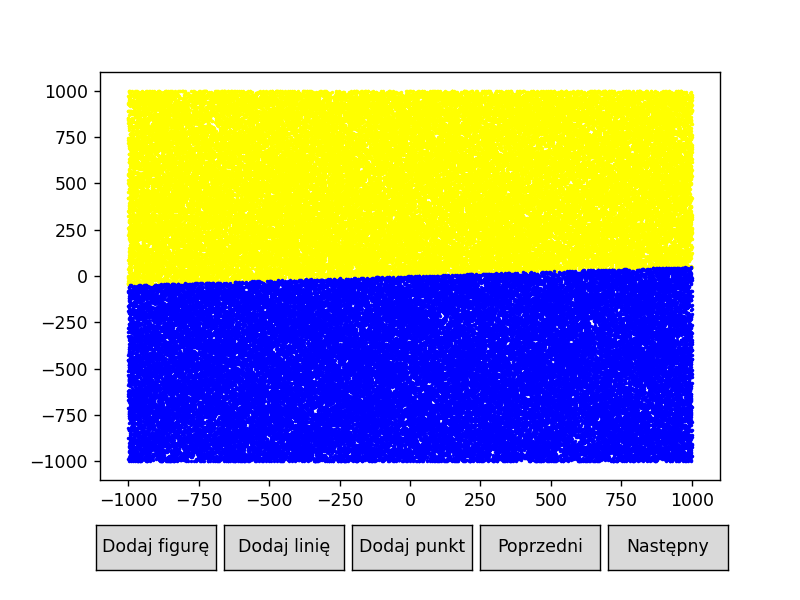

Left:  49824
Right:  50176
Collinear:  0


In [8]:
%matplotlib notebook
arrayOfPoints = orientation(arrayA,v,det3x3)
plotPoints(arrayOfPoints)

<IPython.core.display.Javascript object>


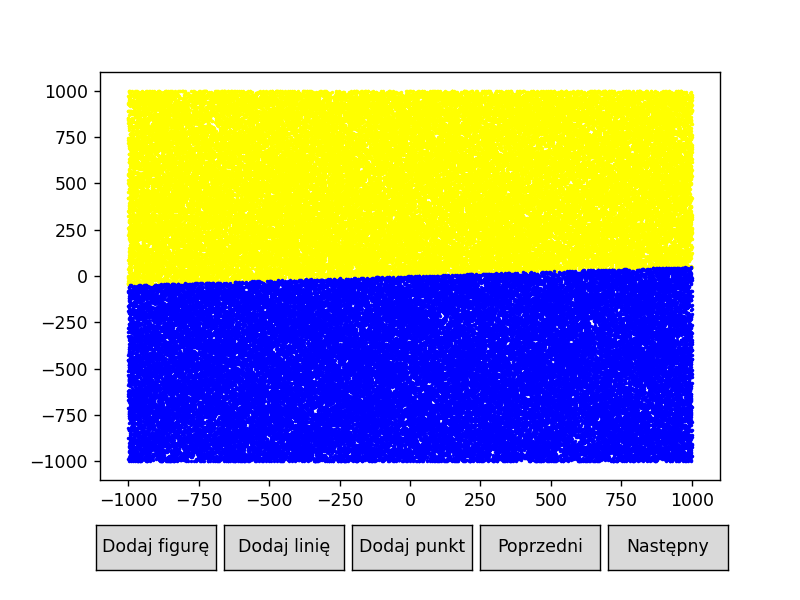

Left:  49824
Right:  50176
Collinear:  0


In [9]:
%matplotlib notebook
arrayOfPoints = orientation(arrayA,v,npDet3x3)
plotPoints(arrayOfPoints)

<IPython.core.display.Javascript object>


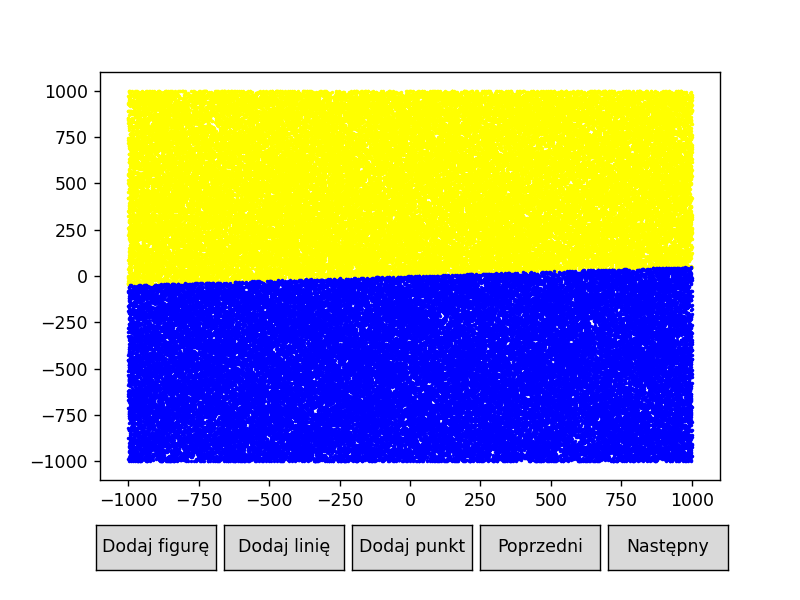

Left:  49824
Right:  50176
Collinear:  0


In [10]:
%matplotlib notebook
arrayOfPoints = orientation(arrayA,v,det2x2)
plotPoints(arrayOfPoints)

<IPython.core.display.Javascript object>


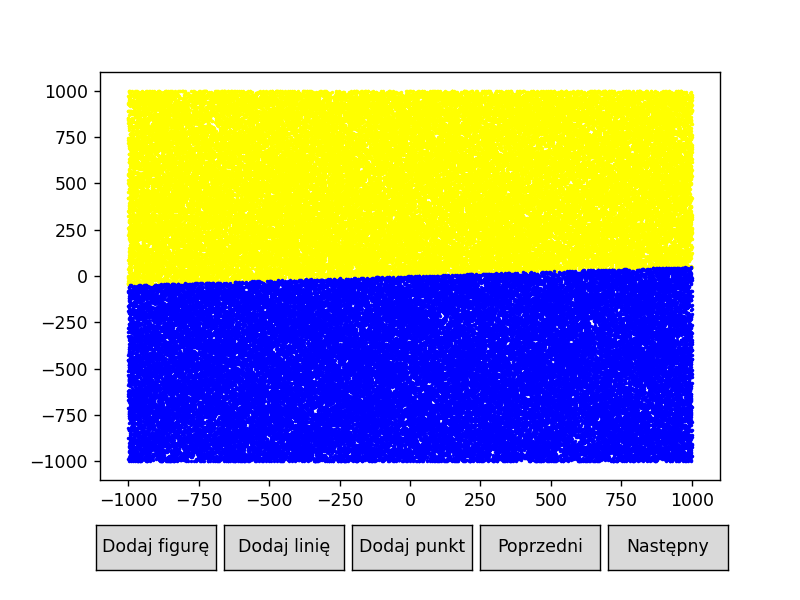

Left:  49824
Right:  50176
Collinear:  0


In [11]:
%matplotlib notebook
arrayOfPoints = orientation(arrayA,v,npDet2x2)
plotPoints(arrayOfPoints)

<IPython.core.display.Javascript object>


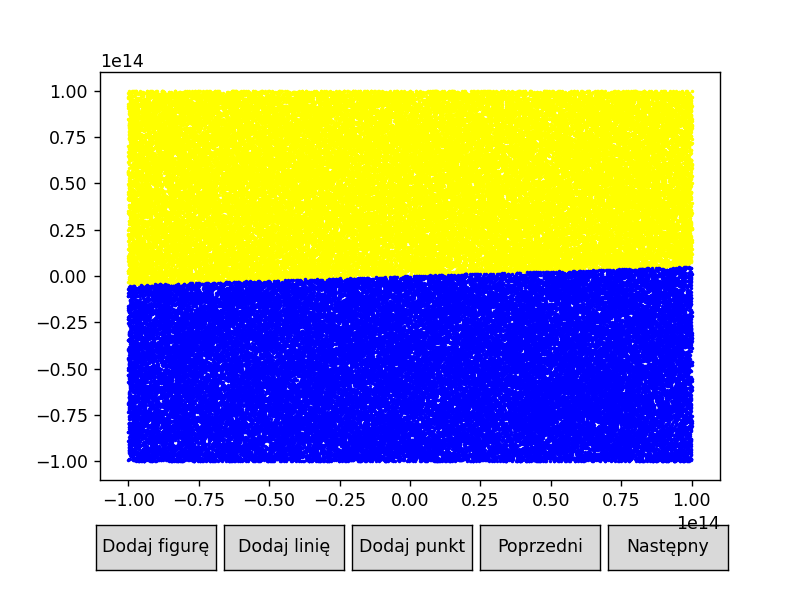

Left:  50029
Right:  49971
Collinear:  0


In [36]:
%matplotlib notebook
arrayOfPoints = orientation(arrayB,v,det3x3)
plotPoints(arrayOfPoints)

<IPython.core.display.Javascript object>


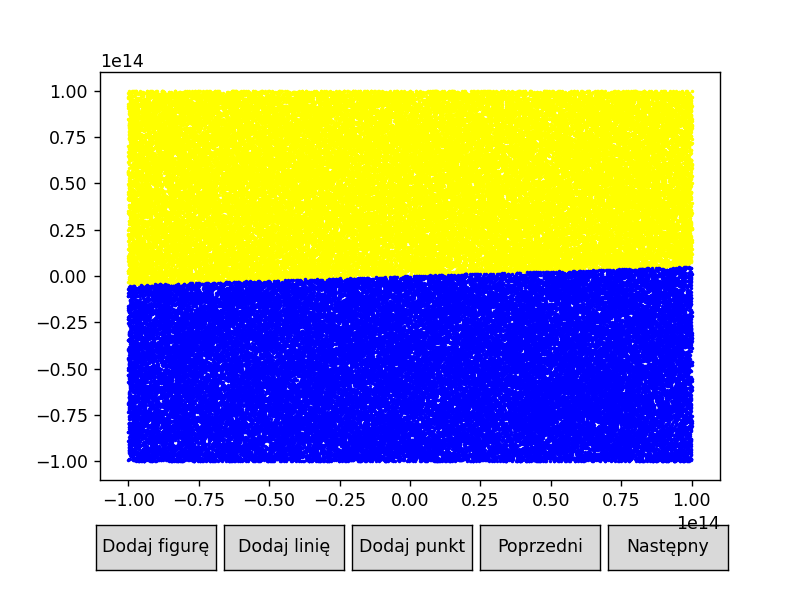

Left:  50029
Right:  49971
Collinear:  0


In [37]:
%matplotlib notebook
arrayOfPoints = orientation(arrayB,v,npDet3x3)
plotPoints(arrayOfPoints)

<IPython.core.display.Javascript object>


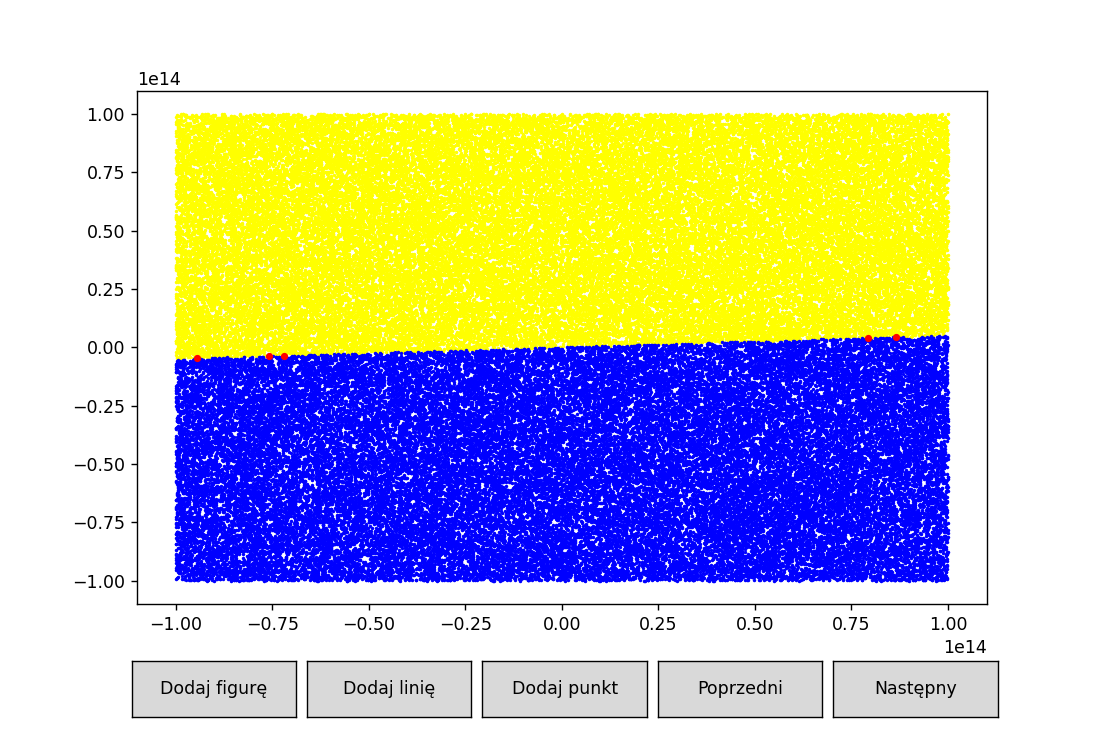

Left:  50026
Right:  49969
Collinear:  5


In [38]:
%matplotlib notebook
arrayOfPoints = orientation(arrayB,v,det2x2)
plotPoints(arrayOfPoints)

<IPython.core.display.Javascript object>


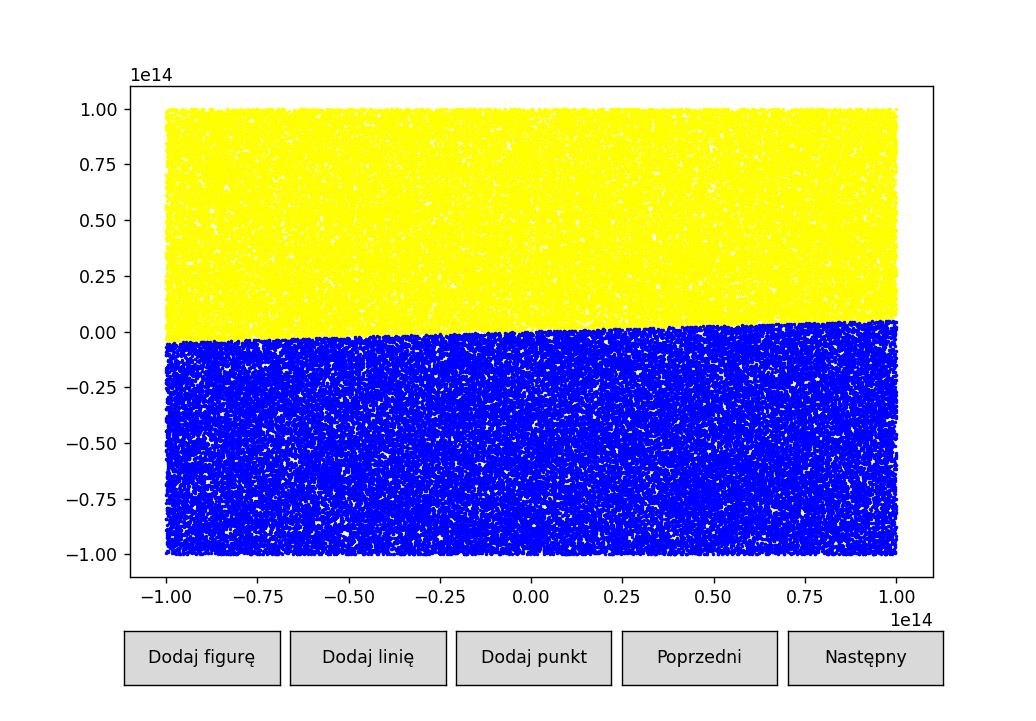

Left:  50028
Right:  49972
Collinear:  0


In [39]:
%matplotlib notebook
arrayOfPoints = orientation(arrayB,v,npDet2x2)
plotPoints(arrayOfPoints)

<IPython.core.display.Javascript object>


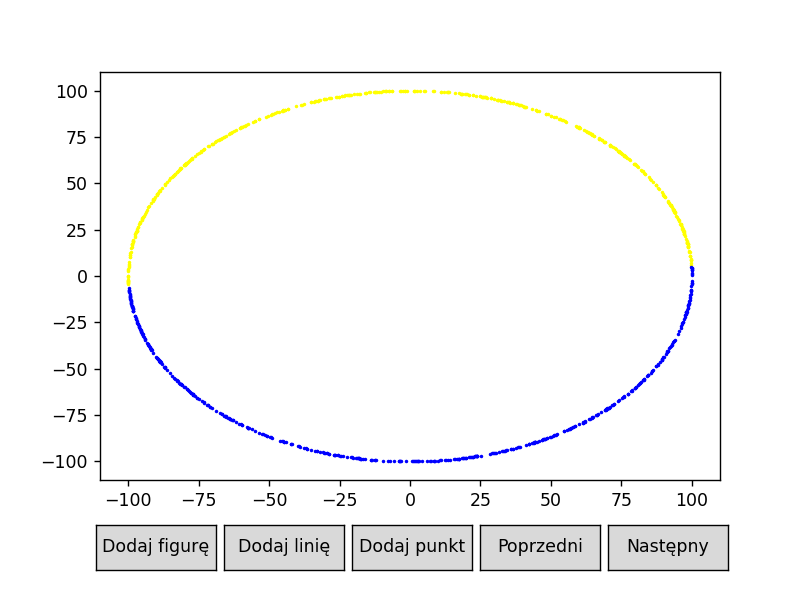

Left:  493
Right:  507
Collinear:  0


In [16]:
%matplotlib notebook
arrayOfPoints = orientation(arrayC,v,det3x3)
plotPoints(arrayOfPoints)

<IPython.core.display.Javascript object>


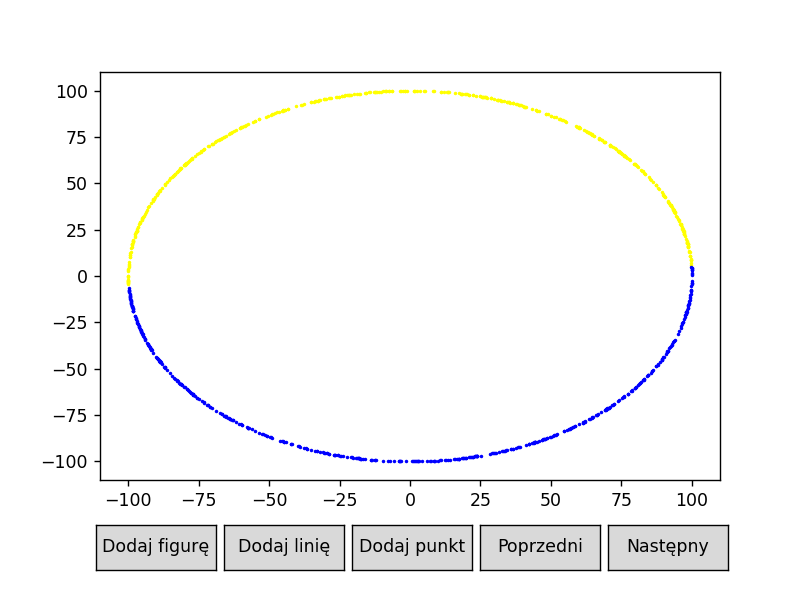

Left:  493
Right:  507
Collinear:  0


In [17]:
%matplotlib notebook
arrayOfPoints = orientation(arrayC,v,npDet3x3)
plotPoints(arrayOfPoints)

<IPython.core.display.Javascript object>


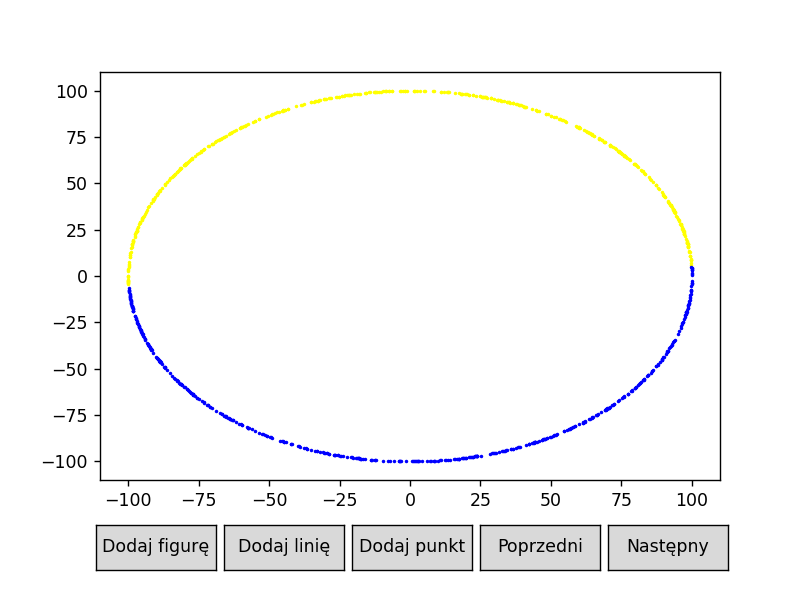

Left:  493
Right:  507
Collinear:  0


In [18]:
%matplotlib notebook
arrayOfPoints = orientation(arrayC,v,det2x2)
plotPoints(arrayOfPoints)

<IPython.core.display.Javascript object>


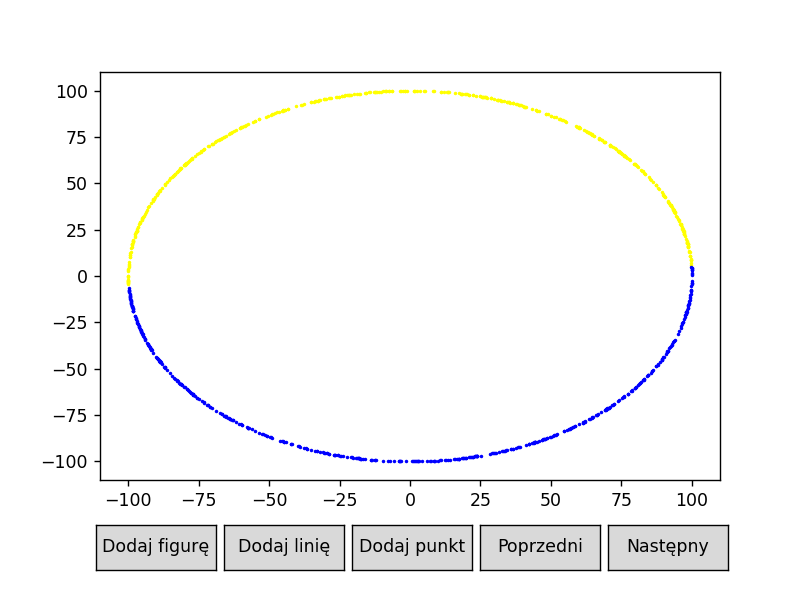

Left:  493
Right:  507
Collinear:  0


In [19]:
%matplotlib notebook
arrayOfPoints = orientation(arrayC,v,npDet2x2)
plotPoints(arrayOfPoints)

<IPython.core.display.Javascript object>


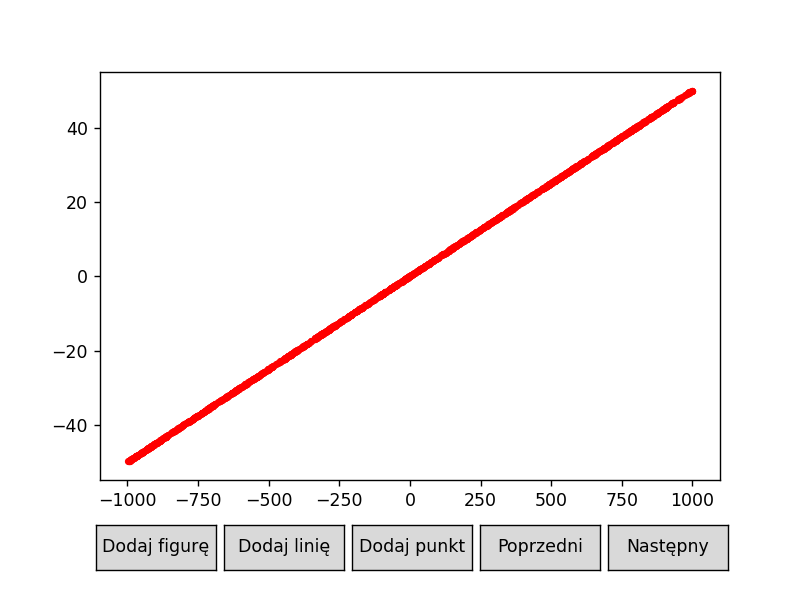

Left:  0
Right:  0
Collinear:  1000


In [40]:
%matplotlib notebook
arrayOfPoints = orientation(arrayD,v,det3x3)
plotPoints(arrayOfPoints)

<IPython.core.display.Javascript object>


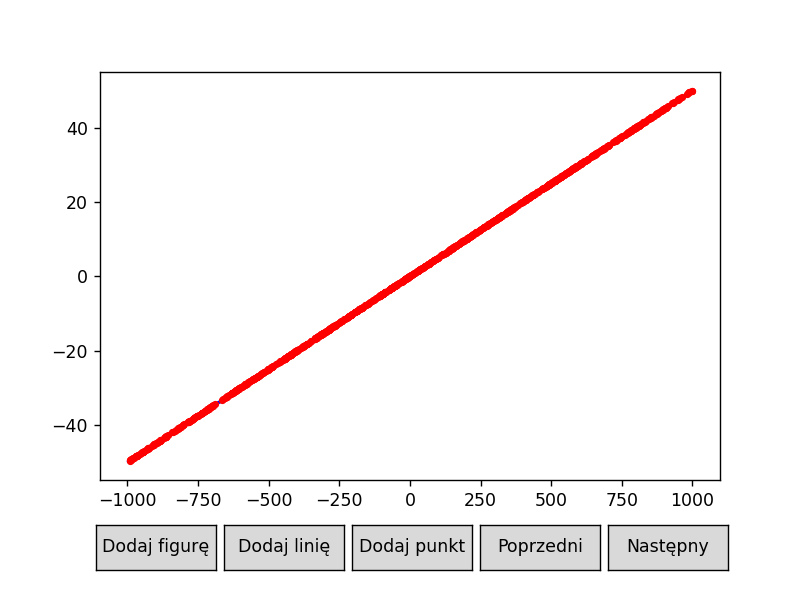

Left:  18
Right:  113
Collinear:  869


In [41]:
%matplotlib notebook
arrayOfPoints = orientation(arrayD,v,npDet3x3)
plotPoints(arrayOfPoints)

<IPython.core.display.Javascript object>


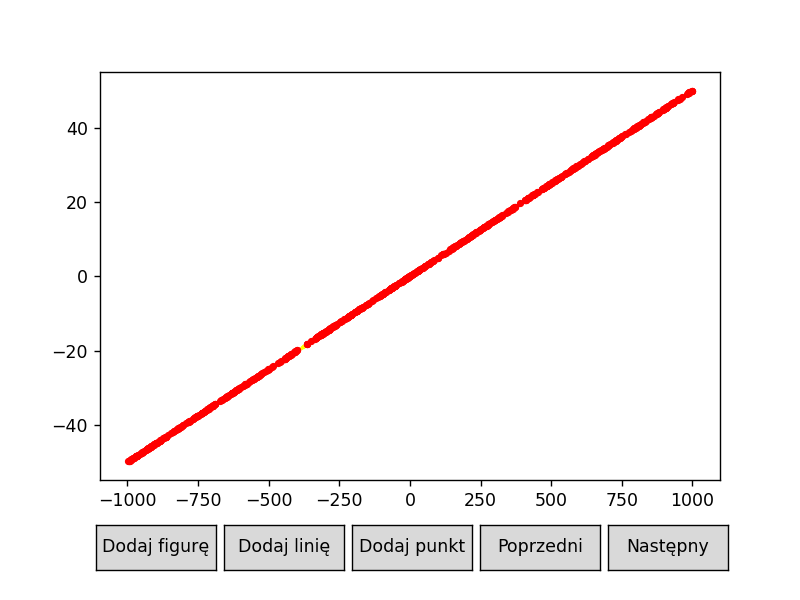

Left:  121
Right:  141
Collinear:  738


In [42]:
%matplotlib notebook
arrayOfPoints = orientation(arrayD,v,det2x2)
plotPoints(arrayOfPoints)

<IPython.core.display.Javascript object>


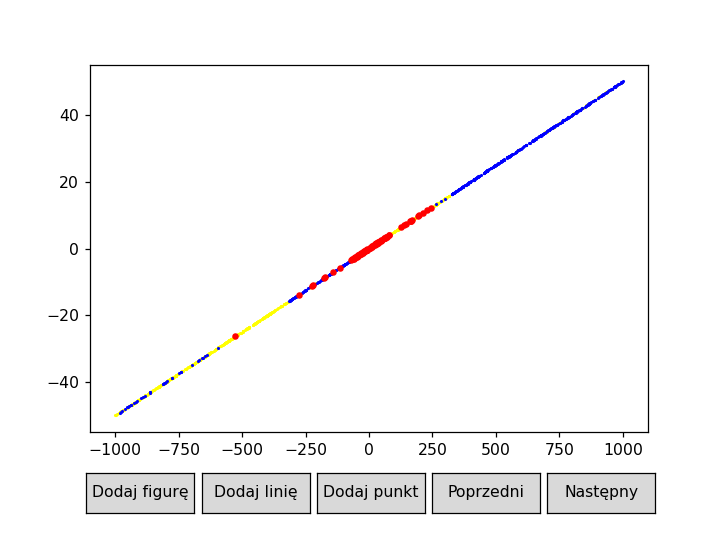

Left:  454
Right:  453
Collinear:  93


In [6]:
%matplotlib notebook
arrayOfPoints = orientation(arrayD,v,npDet2x2)
plotPoints(arrayOfPoints)

Różnice w wynikach:

In [44]:
def differences(array,vector,det1,det2):
    arrayOfPoints1 = orientation(array,vector,det1)
    arrayOfPoints2 = orientation(array,vector,det2)
    diffLeft = list(set(arrayOfPoints1[0]) - set(arrayOfPoints2[0]))
    diffRight = list(set(arrayOfPoints1[1]) - set(arrayOfPoints2[1]))
    diffCollinear = list(set(arrayOfPoints1[2]) - set(arrayOfPoints2[2]))
    diffArray = diffLeft + diffRight + diffCollinear
    diff = len(diffLeft) + len(diffRight) + len(diffCollinear)
    
    plot = Plot(points = [PointsCollection(diffArray,color="red",s=2)])
    plot.draw()
    
    print("Różnica w wyniku :",diff)

<IPython.core.display.Javascript object>


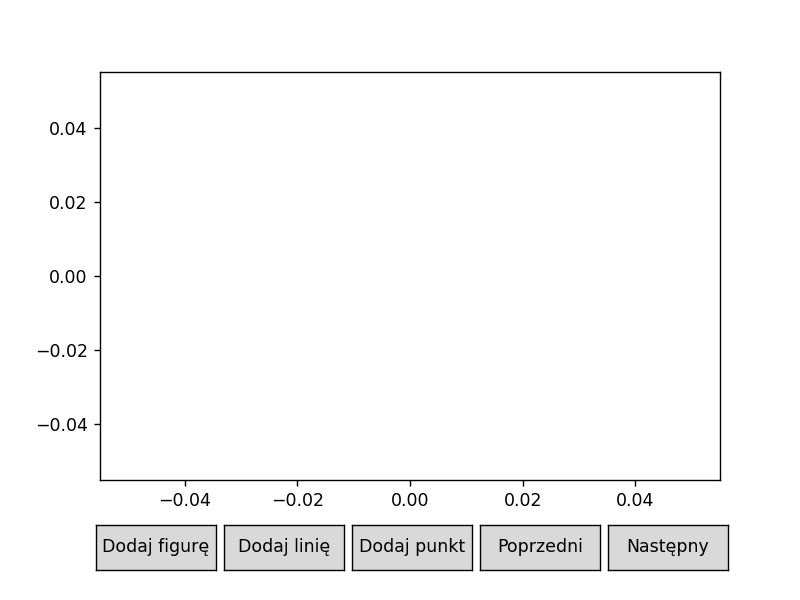

Różnica w wyniku : 0


In [26]:
differences(arrayA,v,det3x3,npDet3x3)

<IPython.core.display.Javascript object>


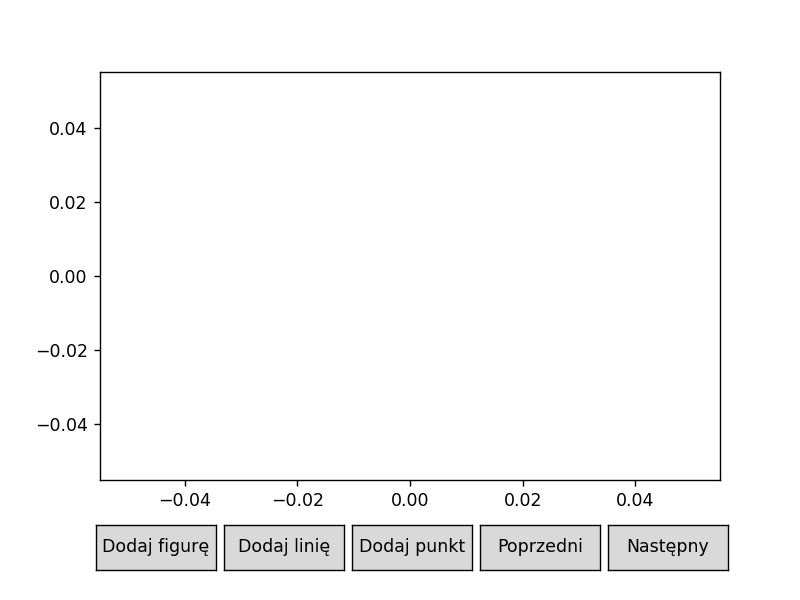

Różnica w wyniku : 0


In [27]:
differences(arrayA,v,det2x2,npDet2x2)

<IPython.core.display.Javascript object>


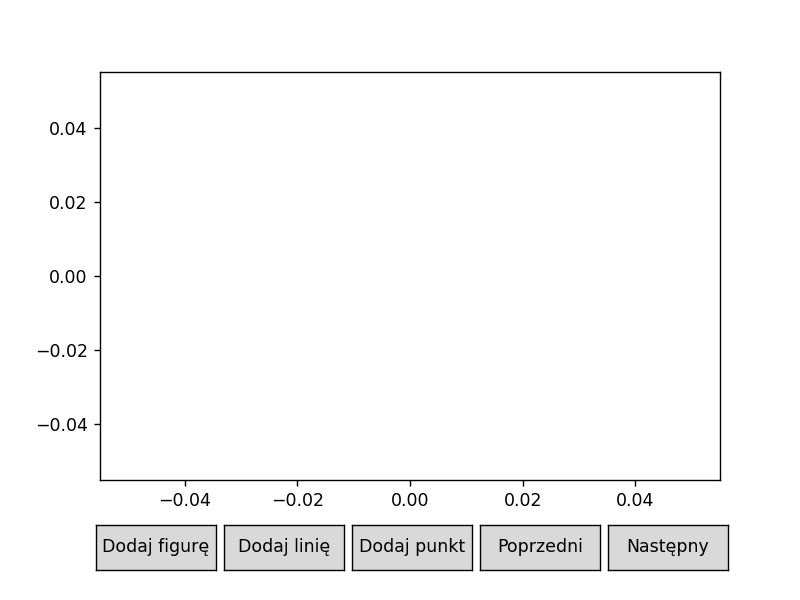

Różnica w wyniku : 0


In [28]:
differences(arrayB,v,det3x3,npDet3x3)

<IPython.core.display.Javascript object>


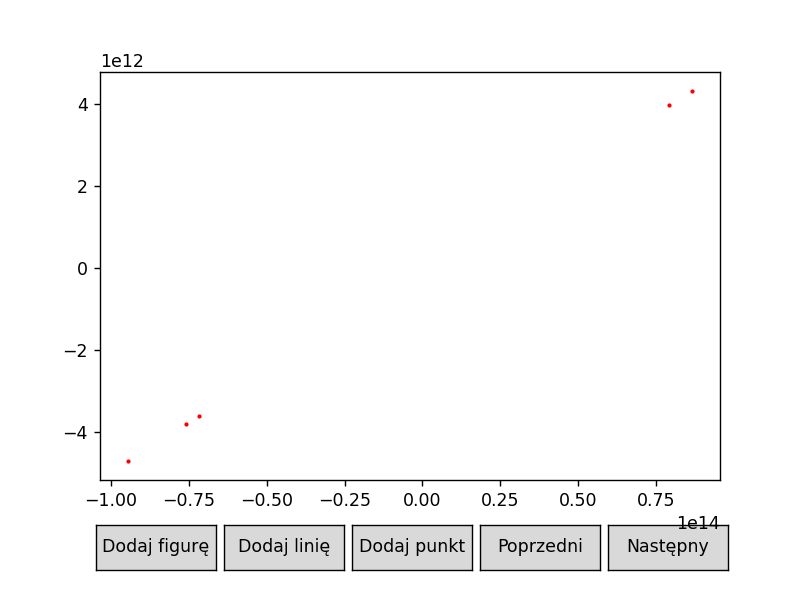

Różnica w wyniku : 5


In [29]:
differences(arrayB,v,det2x2,npDet2x2)

<IPython.core.display.Javascript object>


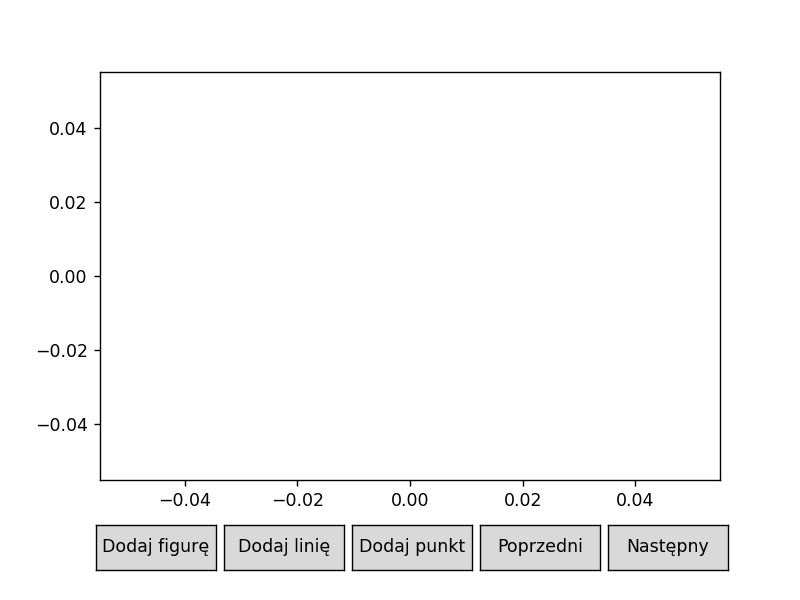

Różnica w wyniku : 0


In [30]:
differences(arrayC,v,det3x3,npDet3x3)

<IPython.core.display.Javascript object>


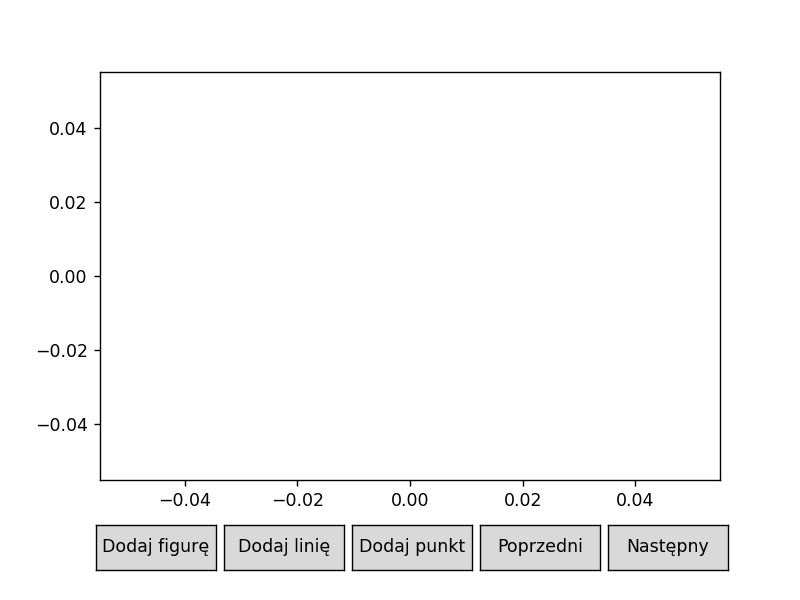

Różnica w wyniku : 0


In [31]:
differences(arrayC,v,det2x2,npDet2x2)

<IPython.core.display.Javascript object>


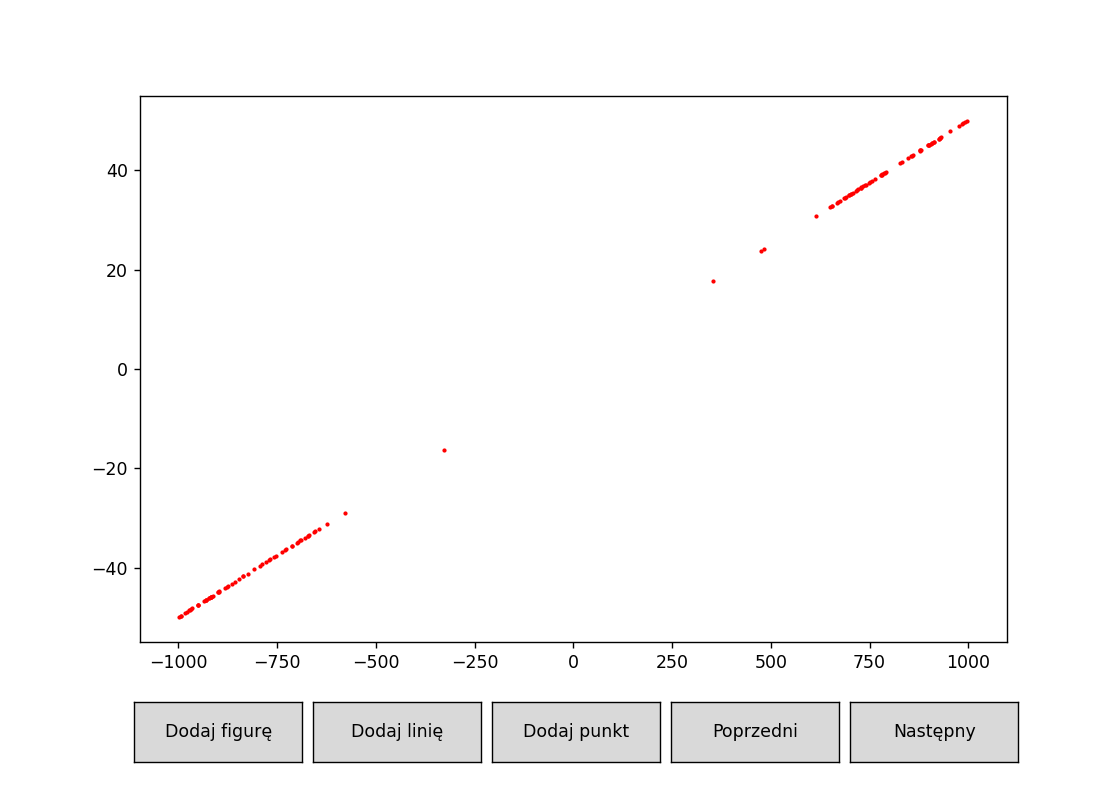

Różnica w wyniku : 131


In [45]:
differences(arrayD,v,det3x3,npDet3x3)

<IPython.core.display.Javascript object>


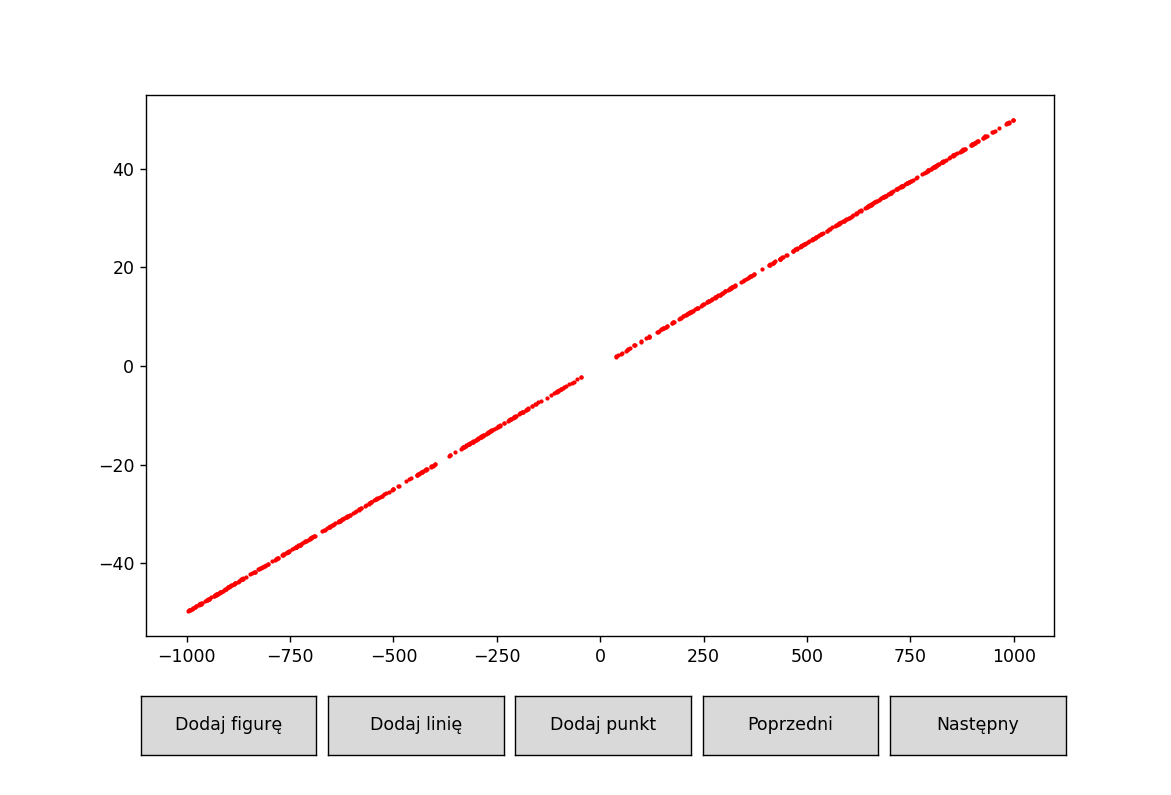

Różnica w wyniku : 683


In [46]:
differences(arrayD,v,det2x2,npDet2x2)

In [34]:
# Pętla użyta do wygenerowania wyników.

arrays = [arrayA,arrayB,arrayC,arrayD]
dets = [det3x3,npDet3x3,det2x2,npDet2x2]
arraysString = ["Dane A: ", "Dane B: ","Dane C: ", "Dane D: "]
for i in range(5,21):
    for j in range(len(arrays)):
        zeroTolerance = 10**(-1*i)
        arrayOfPoints1 = orientation(arrays[j],v,dets[0],zeroTolerance)
        arrayOfPoints2 = orientation(arrays[j],v,dets[1],zeroTolerance)
        diffLeft = list(set(arrayOfPoints1[0]) - set(arrayOfPoints2[0]))
        diffRight = list(set(arrayOfPoints1[1]) - set(arrayOfPoints2[1]))
        diffCollinear = list(set(arrayOfPoints1[2]) - set(arrayOfPoints2[2]))
        diff = len(diffLeft) + len(diffRight) + len(diffCollinear)
        print(arraysString[j])
        print("det3x3 i npDet3x3")
        print("Różnica w wyniku dla tolerancji zera 10**(",-1*i,") wynosi : ",diff,"\n")
        arrayOfPoints1 = orientation(arrays[j],v,dets[2],zeroTolerance)
        arrayOfPoints2 = orientation(arrays[j],v,dets[3],zeroTolerance)
        diffLeft = list(set(arrayOfPoints1[0]) - set(arrayOfPoints2[0]))
        diffRight = list(set(arrayOfPoints1[1]) - set(arrayOfPoints2[1]))
        diffCollinear = list(set(arrayOfPoints1[2]) - set(arrayOfPoints2[2]))
        diff = len(diffLeft) + len(diffRight) + len(diffCollinear)
        print("det2x2 i npDet2x2")
        print("Różnica w wyniku dla tolerancji zera 10**(",-1*i,") wynosi : ",diff)
        print("\n\n")
    print("\n\n\n")
        
    

Dane A: 
det3x3 i npDet3x3
Różnica w wyniku dla tolerancji zera 10**( -5 ) wynosi :  0 

det2x2 i npDet2x2
Różnica w wyniku dla tolerancji zera 10**( -5 ) wynosi :  0



Dane B: 
det3x3 i npDet3x3
Różnica w wyniku dla tolerancji zera 10**( -5 ) wynosi :  0 

det2x2 i npDet2x2
Różnica w wyniku dla tolerancji zera 10**( -5 ) wynosi :  5



Dane C: 
det3x3 i npDet3x3
Różnica w wyniku dla tolerancji zera 10**( -5 ) wynosi :  0 

det2x2 i npDet2x2
Różnica w wyniku dla tolerancji zera 10**( -5 ) wynosi :  0



Dane D: 
det3x3 i npDet3x3
Różnica w wyniku dla tolerancji zera 10**( -5 ) wynosi :  0 

det2x2 i npDet2x2
Różnica w wyniku dla tolerancji zera 10**( -5 ) wynosi :  0







Dane A: 
det3x3 i npDet3x3
Różnica w wyniku dla tolerancji zera 10**( -6 ) wynosi :  0 

det2x2 i npDet2x2
Różnica w wyniku dla tolerancji zera 10**( -6 ) wynosi :  0



Dane B: 
det3x3 i npDet3x3
Różnica w wyniku dla tolerancji zera 10**( -6 ) wynosi :  0 

det2x2 i npDet2x2
Różnica w wyniku dla tolerancji zera 10

Dane A: 
det3x3 i npDet3x3
Różnica w wyniku dla tolerancji zera 10**( -17 ) wynosi :  0 

det2x2 i npDet2x2
Różnica w wyniku dla tolerancji zera 10**( -17 ) wynosi :  0



Dane B: 
det3x3 i npDet3x3
Różnica w wyniku dla tolerancji zera 10**( -17 ) wynosi :  0 

det2x2 i npDet2x2
Różnica w wyniku dla tolerancji zera 10**( -17 ) wynosi :  5



Dane C: 
det3x3 i npDet3x3
Różnica w wyniku dla tolerancji zera 10**( -17 ) wynosi :  0 

det2x2 i npDet2x2
Różnica w wyniku dla tolerancji zera 10**( -17 ) wynosi :  0



Dane D: 
det3x3 i npDet3x3
Różnica w wyniku dla tolerancji zera 10**( -17 ) wynosi :  549 

det2x2 i npDet2x2
Różnica w wyniku dla tolerancji zera 10**( -17 ) wynosi :  744







Dane A: 
det3x3 i npDet3x3
Różnica w wyniku dla tolerancji zera 10**( -18 ) wynosi :  0 

det2x2 i npDet2x2
Różnica w wyniku dla tolerancji zera 10**( -18 ) wynosi :  0



Dane B: 
det3x3 i npDet3x3
Różnica w wyniku dla tolerancji zera 10**( -18 ) wynosi :  0 

det2x2 i npDet2x2
Różnica w wyniku dla tol